In [49]:
from kan import *
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset



In [50]:

'''
f = lambda x: torch.exp(torch.tanh(x[:,[0]]**2)) + x[:,[1]]
dataset = create_dataset(f, n_var=2)
dataset['train_input'].shape, dataset['train_label'].shape
'''

train_data = pd.read_csv('/home/yjain0201/Yash Machine Learning Code/temps and summit pressure frAfr for NN.csv', sep=',')
train_data.pop('date')
train_data.dropna(inplace=True)
print(train_data)

train_data.head()

training_array = np.array(train_data, dtype='float')
print(len(training_array))
'''
def split_array(arr):
    batch_size = len(arr) // 4
    batch1 = arr[:batch_size]
    batch2 = arr[batch_size:2*batch_size]
    batch3 = arr[2*batch_size:3*batch_size]
    batch4 = arr[3*batch_size:]
    train = []
    test = []
    trained_random_sample_nums = []
    for i in range(1, 5):
        batch_name = 'batch' + str(i)
        available_indices = list(range(len(eval(batch_name)))) 
        for j in range(0, 1500):
            random_sample_number = random.sample(available_indices, 1)[0]  
            trained_random_sample_nums.append(random_sample_number)
            if batch_name == 'batch1':
                train.append(batch1[random_sample_number])
                available_indices.remove(random_sample_number)  
            elif batch_name == 'batch2':
                train.append(batch2[random_sample_number])
                available_indices.remove(random_sample_number)  
            elif batch_name == 'batch3':
                train.append(batch3[random_sample_number])
                available_indices.remove(random_sample_number) 
            elif batch_name == 'batch4':
                train.append(batch4[random_sample_number])
                available_indices.remove(random_sample_number)  
                
    train = np.array(train)
    x_train = train[:, [0,1,2,4,8]]
    y_train = train[:, [3,5,6,7]]
    #x_train = train[:, :5]
    #y_train = train[:, 5:]
    
    for i in range(1, 5):
        batch_name = 'batch' + str(i)
        available_indices = list(range(len(eval(batch_name))))  
        for j in range(0, 700):
            random_sample_number = random.sample(available_indices, 1)[0]  
            if batch_name == 'batch1':
                test.append(batch1[random_sample_number])
                available_indices.remove(random_sample_number)  
            elif batch_name == 'batch2':
                test.append(batch2[random_sample_number])
                available_indices.remove(random_sample_number)  
            elif batch_name == 'batch3':
                test.append(batch3[random_sample_number])
                available_indices.remove(random_sample_number)  
            elif batch_name == 'batch4':
                test.append(batch4[random_sample_number])
                available_indices.remove(random_sample_number)  
    
    test = np.array(test)
    x_test = test[:, [0,1,2,4,8]]
    y_test = test[:, [3,5,6,7]]

    return x_train, y_train, x_test, y_test
'''
def split_array(arr):
    batch_size = len(arr) // 4
    batches = [arr[i*batch_size:(i+1)*batch_size] for i in range(4)]
    
    train, test = [], []
    
    for batch in batches:
        train_indices = random.sample(range(len(batch)), 8000)
        test_indices = random.sample([i for i in range(len(batch)) if i not in train_indices], 2000)
        
        train.extend(batch[i] for i in train_indices)
        test.extend(batch[i] for i in test_indices)
    
    train = np.array(train)
    test = np.array(test)
    
    x_train, y_train = train[:, [0,1,2,4,8]], train[:, [3,5,6,7]]
    x_test, y_test = test[:, [0,1,2,4,8]], test[:, [3,5,6,7]]
    
    return x_train, y_train, x_test, y_test


/tmp/ipykernel_1280/1138805792.py:7: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/home/yjain0201/Yash Machine Learning Code/temps and summit pressure frAfr for NN.csv', sep=',')


        station_pressure  relative_humidity  AR16Temperature  AR33Temperature  \
0                794.817               96.0             30.6             20.6   
1                794.836               96.0             30.6             20.6   
2                795.024               96.0             30.6             20.6   
3                794.635               96.0             30.7             20.6   
4                794.763               96.0             30.8             20.5   
...                  ...                ...              ...              ...   
526006           785.920               84.0             13.9              4.7   
526007           786.183               84.0             13.9              4.7   
526008           785.948               84.0             13.9              4.6   
526009           786.013               84.0             13.9              4.6   
526010           785.924               84.0             13.9              4.6   

        AR40Temperature  AR

In [51]:
xtr, ytr, xte, yte = split_array(training_array)
xtr, ytr, xte, yte = torch.from_numpy(xtr).float(), torch.from_numpy(ytr).float(), torch.from_numpy(xte).float(), torch.from_numpy(yte).float()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
xtr, ytr, xte, yte = xtr.to(device), ytr.to(device), xte.to(device), yte.to(device)



In [52]:
'''
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, x_test, y_test):
        self.data = {
            'train_input': x_train,
            'train_label': y_train,
            'test_input': x_test,
            'test_label': y_test
        }
    
    def __getitem__(self, index):
        return {key: self.data[key][index] for key in self.data.keys()}
    
    def __len__(self):
        return len(self.data['train_input'])
'''
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train, x_test, y_test, device):
        self.data = {
            'train_input': x_train.to(device),
            'train_label': y_train.to(device),
            'test_input': x_test.to(device),
            'test_label': y_test.to(device)
        }
    
    def __getitem__(self, key):
        return self.data[key]
    
    def __len__(self):
        return len(self.data['train_input']) + len(self.data['test_input'])
dataset = CustomDataset(x_train=xtr, y_train=ytr, x_test=xte, y_test=yte, device=device)

In [47]:
print()
print(device)

torch.Size([32000, 5])
cuda


In [29]:
import torch.nn as nn

def train_model(model, x_train, y_train, x_test, y_test, steps=20, epochs=10, lambda_reg=0.001, lamb_entropy=5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001)

    def closure():
        optimizer.zero_grad()
        outputs = model(x_train)
        loss = criterion(outputs, y_train)

        reg_loss = 0.5 * lambda_reg * sum(torch.norm(param)**2 for param in model.parameters())
        entropy_loss = -lamb_entropy * torch.mean(torch.sum(torch.softmax(outputs, dim=1) * torch.log_softmax(outputs, dim=1), dim=1))
        total_loss = loss + reg_loss + entropy_loss

        total_loss.backward()
        return total_loss

    for epoch in range(epochs):
        for step in range(steps):
            optimizer.step(closure)
            print(f'Epoch [{epoch+1}/{epochs}], Step [{step+1}/{steps}], Loss: {closure().item()}')
            





In [30]:
train_model(model, xtr, ytr, xte, yte, steps=20, epochs=10, lambda_reg=0.001, lamb_entropy=5)



Epoch [1/10], Step [1/20], Loss: 1551225361.9205744


description:   0%|                                                           | 0/40 [07:16<?, ?it/s]


Epoch [1/10], Step [2/20], Loss: 1269067203.3673904
Epoch [1/10], Step [3/20], Loss: 1055875183.4557767
Epoch [1/10], Step [4/20], Loss: 878121552.3042969
Epoch [1/10], Step [5/20], Loss: 728860743.4625632
Epoch [1/10], Step [6/20], Loss: 625583895.8383584
Epoch [1/10], Step [7/20], Loss: 535777225.09161055
Epoch [1/10], Step [8/20], Loss: 445511156.4187972
Epoch [1/10], Step [9/20], Loss: 362086018.3981341
Epoch [1/10], Step [10/20], Loss: 290331165.50519764
Epoch [1/10], Step [11/20], Loss: 240343581.77077872
Epoch [1/10], Step [12/20], Loss: 196582401.2207565
Epoch [1/10], Step [13/20], Loss: 159019508.76573038
Epoch [1/10], Step [14/20], Loss: 135729982.58859244
Epoch [1/10], Step [15/20], Loss: 117675147.42079785
Epoch [1/10], Step [16/20], Loss: 30970263.499190845
Epoch [1/10], Step [17/20], Loss: 23123597.415354274
Epoch [1/10], Step [18/20], Loss: 18987274.942016568
Epoch [1/10], Step [19/20], Loss: 16171576.524011062
Epoch [1/10], Step [20/20], Loss: 12871175.09681507


RuntimeError: The size of tensor a (2800) must match the size of tensor b (4) at non-singleton dimension 1

In [53]:
model = KAN(width=[5,8,16,32,64,32,16,8,4], grid=5, k=4, seed=0)
model = model.to(device)
data_dict = {
    'train_input': dataset['train_input'],
    'train_label': dataset['train_label'],
    'test_input': dataset['test_input'],
    'test_label': dataset['test_label']
}
model.train(dataset = data_dict, opt="LBFGS", steps=60, lamb=0.01, lamb_entropy=10.)








description:   0%|                                                           | 0/60 [00:00<?, ?it/s]


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_CUDA_bmm)

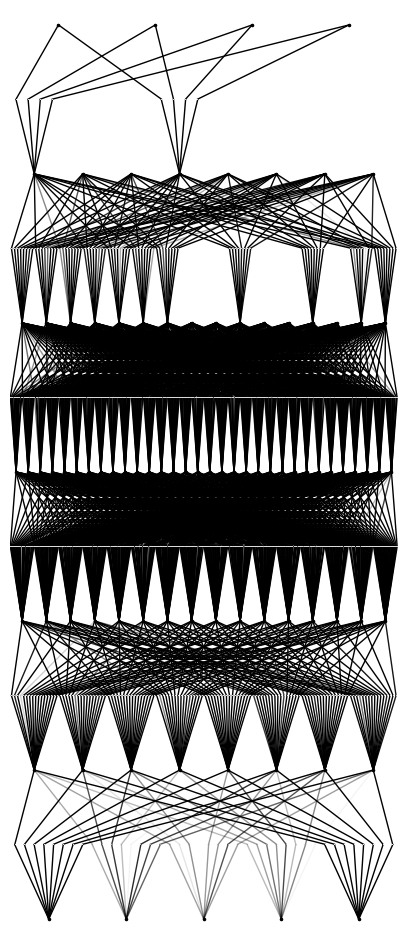

In [36]:
model.plot()


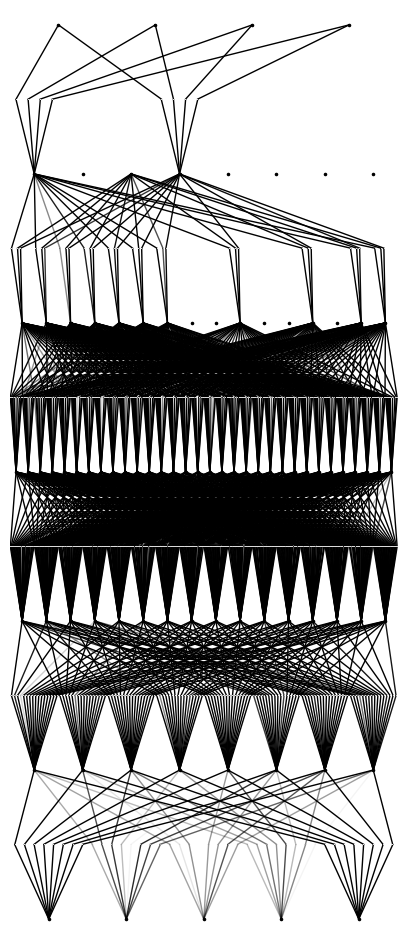

In [37]:
model.prune(threshold=0.0001)
model(dataset.data['train_input'])
model.plot()

In [38]:
torch.save(model.state_dict(), r'C:\Users\observer\Desktop\Yash Machine Learning Code\Saved Models\KAN_32.pth')
#model.train(dataset, opt="LBFGS", steps=50)

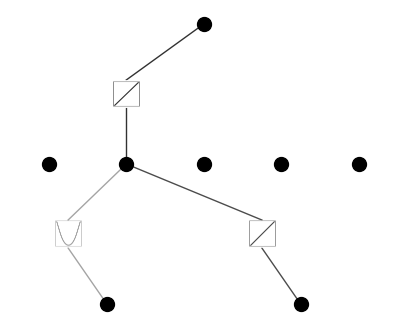

In [9]:
model.plot()

In [11]:
#model.train(dataset, opt="LBFGS", steps=50)

train loss: 4.08e-04 | test loss: 5.62e-04 | reg: 7.52e+00 : 100%|██| 50/50 [00:11<00:00,  4.24it/s]


{'train_loss': [array(0.01656318, dtype=float32),
  array(0.00888684, dtype=float32),
  array(0.00596633, dtype=float32),
  array(0.00505055, dtype=float32),
  array(0.00460433, dtype=float32),
  array(0.00396018, dtype=float32),
  array(0.00333948, dtype=float32),
  array(0.00262036, dtype=float32),
  array(0.00235429, dtype=float32),
  array(0.00208608, dtype=float32),
  array(0.00190817, dtype=float32),
  array(0.00174706, dtype=float32),
  array(0.00162479, dtype=float32),
  array(0.00153184, dtype=float32),
  array(0.00145646, dtype=float32),
  array(0.00138851, dtype=float32),
  array(0.00133946, dtype=float32),
  array(0.00128317, dtype=float32),
  array(0.00122705, dtype=float32),
  array(0.00114287, dtype=float32),
  array(0.00107653, dtype=float32),
  array(0.00103569, dtype=float32),
  array(0.00100548, dtype=float32),
  array(0.0009799, dtype=float32),
  array(0.00093855, dtype=float32),
  array(0.00088551, dtype=float32),
  array(0.00082857, dtype=float32),
  array(0.00077

KAN(
  (biases): ModuleList(
    (0): Linear(in_features=5, out_features=1, bias=False)
    (1): Linear(in_features=1, out_features=1, bias=False)
  )
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

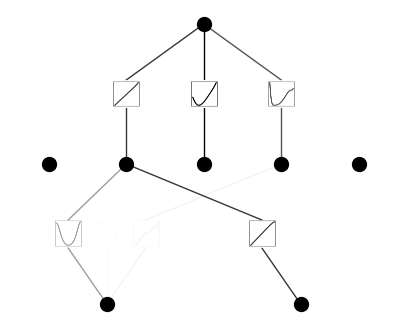

In [13]:
#model.plot()
#model.prune()

In [10]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
model.auto_symbolic(lib=lib)

fixing (0,0,0) with abs, r2=0.0
fixing (0,0,1) with x^2, r2=0.9994379281997681
fixing (0,0,2) with abs, r2=0.0
fixing (0,0,3) with abs, r2=0.0
fixing (0,0,4) with abs, r2=0.0
fixing (0,1,0) with abs, r2=0.0
fixing (0,1,1) with abs, r2=1.0000003576278687
fixing (0,1,2) with abs, r2=0.0
fixing (0,1,3) with abs, r2=0.0
fixing (0,1,4) with abs, r2=0.0
fixing (1,0,0) with abs, r2=0.0
fixing (1,1,0) with abs, r2=1.0000003576278687
fixing (1,2,0) with abs, r2=0.0
fixing (1,3,0) with abs, r2=0.0
fixing (1,4,0) with abs, r2=0.0


In [11]:
model.train(dataset, opt="LBFGS", steps=50)

train loss: 8.62e-03 | test loss: 8.46e-03 | reg: 2.90e+00 : 100%|██| 50/50 [00:04<00:00, 12.27it/s]


{'train_loss': [array(0.00862126, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.00861555, dtype=float32),
  array(0.0086

In [12]:
model.symbolic_formula()[0][0]

0.15*Abs(7.67*x_1**2 + 0.81*Abs(8.04*x_2 + 9.6) + 3.02) - 0.67

Working at home now :)

In [22]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAN(width=[5,8,16,32,16,8,4], grid=5, k=4, seed=0)
model.load_state_dict(torch.load('/home/yjain0201/Yash Machine Learning Code/Saved Models/KAN_32.pth'))
#model = model.to(device)
model.eval()



TypeError: 'bool' object is not subscriptable